In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time
from gprofiler import GProfiler
import gseapy as gp

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [6]:
# Set file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
GS_FILE=DATA_PATH+'/gs_file/magma_10kb_1000.gs'
TRAIT_INFO_FILE=DATA_PATH+'/supp_table/trait_info_full.tsv'
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_tcell'

# Set data info
DS_LIST = ['facs', 'droplet', 'canogamez']
# DS_LIST = ['facs']
DIC_INFO = {}
DIC_INFO['facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
DIC_INFO['droplet'] = {'species': 'mmusculus', 'dname': 'TMS Droplet'}
DIC_INFO['canogamez'] = {'species': 'hsapiens', 'dname': 'Human CD4 T cells'}

# Set score file
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_1000',
                  'droplet': DATA_PATH+'/score_file/score.tms_droplet_with_cov.magma_10kb_1000',
                  'canogamez': DATA_PATH+'/score_file/score.canogamez_with_cov.magma_10kb_1000',
                  'facs_tsig': DATA_PATH+'/score_file/score.tms_facs_with_cov.tcell_sig',
                  'droplet_tsig': DATA_PATH+'/score_file/score.tms_droplet_with_cov.tcell_sig'
                 }

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['facs'] = ['PASS_CD_deLange2017', 
                          'PASS_IBD_deLange2017',
                          'PASS_Multiple_sclerosis',
                          'PASS_Rheumatoid_Arthritis',
                          'PASS_UC_deLange2017',
                          'UKB_460K.disease_AID_ALL', 
                          'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED',
                          'UKB_460K.disease_ASTHMA_DIAGNOSED', 
                          'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
                          'UKB_460K.disease_RESPIRATORY_ENT']
DIC_TRAIT_LIST['facs_tsig'] = ['naive_cd4', 'memory_cd4', 'effector_cd4', 'reg_cd4', 
                               'naive_cd8', 'memory_cd8', 'effector_cd8']
DIC_TRAIT_LIST['droplet'] = DIC_TRAIT_LIST['facs']
DIC_TRAIT_LIST['canogamez'] = DIC_TRAIT_LIST['facs']
DIC_TRAIT_LIST['droplet_tsig'] = DIC_TRAIT_LIST['facs_tsig']

# Set trait info
DF_TRAIT_INFO = pd.read_csv(TRAIT_INFO_FILE, sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
temp_dic = {'naive_cd4':'Naive Cd4', 'memory_cd4':'Memory Cd4', 'effector_cd4':'Effector Cd4', 'reg_cd4':'Treg',
            'naive_cd8':'Naive Cd8', 'memory_cd8':'Memory Cd8', 'effector_cd8':'Effector Cd8'}
for trait in temp_dic:
    DF_TRAIT_INFO.loc[trait, ['Trait_Identifier', 'Code']] = [trait, temp_dic[trait]]
for trait in DF_TRAIT_INFO.index[DF_TRAIT_INFO['Code'].isna()]:
    trait_short = trait.replace('PASS_','').replace('UKB_460K.','')
    trait_short = trait_short.replace('blood_','').replace('disease_','')
    DF_TRAIT_INFO.loc[trait, 'Code'] = trait_short

### Load data 

In [3]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')
dic_data_raw['droplet'] = dl.load_tms_ct(DATA_PATH, data_name='droplet')
dic_data_raw['canogamez'] = dl.load_canogamez_raw_data()
dic_data_raw['canogamez'].obs['cell_ontology_class'] = dic_data_raw['canogamez'].obs['cluster.id']

dic_data_proc = {}
dic_data_proc['facs'] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
                                  'tcell.facs.annot.h5ad')
dic_data_proc['droplet'] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/'
                                     'tms_proc/tcell.droplet.h5ad')
dic_data_proc['canogamez'] = dl.load_canogamez_raw_data(opt='processed')
dic_data_proc['canogamez'].obs['cell_ontology_class'] = dic_data_proc['canogamez'].obs['cluster.id']

Trying to set attribute `.obs` of view, copying.


In [7]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.score.gz'%trait)
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

# Cell list to analyze
dic_cell_list = {}
for score in DIC_SCORE_PATH:
    ds = score.replace('_tsig','')
    dic_cell_list[score] = list(set(dic_data_proc[ds].obs_names) & set(dic_score[score].index))

# missing: /n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.tms_droplet_with_cov.magma_10kb_1000/PASS_CD_deLange2017.score.gz
# missing: /n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.tms_droplet_with_cov.magma_10kb_1000/PASS_Rheumatoid_Arthritis.score.gz
# missing: /n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.tms_droplet_with_cov.magma_10kb_1000/PASS_UC_deLange2017.score.gz


In [45]:
# Load control score 
dic_ctrl_score = {}
for score in DIC_SCORE_PATH:
    ds = score.replace('_tsig','')
    dic_ctrl_score[score] = {}
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.full_score.gz'%trait)
        if os.path.exists(file_path):
            print('# Loading %s %s'%(score, trait))
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df = temp_df.loc[set(dic_data_proc[ds].obs_names) & set(temp_df.index)]
            dic_ctrl_score[score][trait] = temp_df.copy()
        else:
            print('# missing: %s'%file_path)
            continue
        dic_ctrl_score[score][trait] = dic_ctrl_score[score][trait].loc[dic_cell_list[score]].copy()

# Loading facs PASS_CD_deLange2017
# Loading facs PASS_IBD_deLange2017
# Loading facs PASS_Multiple_sclerosis
# Loading facs PASS_Rheumatoid_Arthritis
# Loading facs PASS_UC_deLange2017
# Loading facs UKB_460K.disease_AID_ALL
# Loading facs UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED
# Loading facs UKB_460K.disease_ASTHMA_DIAGNOSED
# Loading facs UKB_460K.disease_HYPOTHYROIDISM_SELF_REP
# Loading facs UKB_460K.disease_RESPIRATORY_ENT
# missing: /n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.tms_droplet_with_cov.magma_10kb_1000/PASS_CD_deLange2017.full_score.gz
# Loading droplet PASS_IBD_deLange2017
# Loading droplet PASS_Multiple_sclerosis
# missing: /n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.tms_droplet_with_cov.magma_10kb_1000/PASS_Rheumatoid_Arthritis.full_score.gz
# missing: /n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.tms_droplet_with_cov.magma_10kb_1000/PASS_UC_deLange2017.full_score.gz
# Loading dropl

### Canogamez associations 

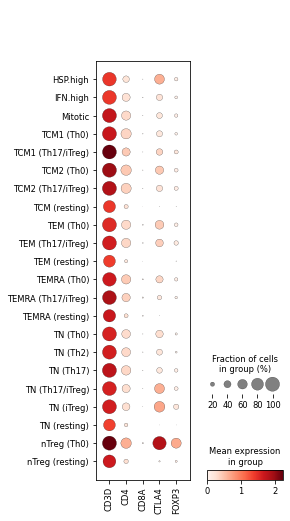

In [46]:
trait = 'PASS_IBD_deLange2017'
ds = 'canogamez'

# Assign sig label for each leiden cluster (remove sig cells in small clusters)
# adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata = dic_data_raw[ds][dic_cell_list[ds], :].copy()
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obs = adata.obs.join(temp_adata.obs[[x for x in temp_adata.obs.columns if x not in adata.obs.columns]])
adata.obsm = temp_adata.obsm

# Marker gene expression 
marker_list = ['CD3D', 'CD4', 'CD8A', # Basic
#                'Sell', 'Ccr7', 'Npm1', 'Cd44', # Naive Cd44-               
#                'Cd69', 'Tfrc', 'Il2ra', 'Tnfrsf4', # Activation: Cd69, Cd71, Cd25 (also Treg)
               'CTLA4', 'FOXP3', # Treg
#                'Gzmk', 'Gzmb', 'Gzma', 'Prf1', 'Ifng', 'Fasl', # Cd8+ cytotoxic T cells
#                'Il7r', 'Tnfsf13b', 'Ccl4', 'Ccl5', # effector memory
#                'Icos', 'Nfkbia', 'Nfkbiz', 'Klrg1', 'Pdcd1', # Others
              ]
sc.pl.dotplot(adata, marker_list, groupby='cluster.id')

In [62]:
# Associations
cell_list = list(set(dic_score[ds].index) & set(adata.obs_names))
trait = 'PASS_IBD_deLange2017'
df_plot = pd.DataFrame(index=cell_list)
df_plot = df_plot.join(dic_score[ds][['%s.norm_score'%trait, '%s.fdr'%trait]])
df_plot = df_plot.join(adata.obs[['cytokine.condition', 'cluster.id', 'effectorness']])

temp_df = df_plot.loc[df_plot['%s.fdr'%trait]<0.1]
temp_df = temp_df.groupby('cluster.id').agg({'effectorness':len})
temp_df = temp_df.loc[temp_df['effectorness']>5]
display(temp_df)

,effectorness
cluster.id,
TEM (Th17/iTreg),17.0
TN (Th17/iTreg),45.0
nTreg (Th0),19.0


In [68]:
adata.obs['cell.type'].unique()

[Naive, Memory]
Categories (2, object): [Naive, Memory]

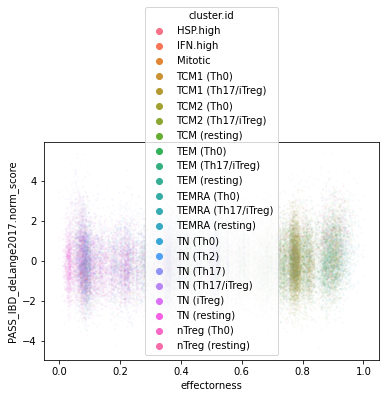

In [66]:
plt.figure()
sns.scatterplot(data=df_plot, x='effectorness', y='%s.norm_score'%trait, hue='cluster.id', s=4, alpha=0.05)
plt.show()

In [58]:
# Compute p-value
adata = dic_data_proc['canogamez'].copy()
# adata = adata[adata.obs['cytokine.condition']=='UNS',:]
df_stats = pd.DataFrame(columns=['DPT', 'TRAIT', 'CORR', 'P'])
dpt = 'effectorness'
score = 'canogamez'

for trait in DIC_TRAIT_LIST[score]:
    df_plot = adata.obs[[dpt]].copy()
    df_plot = df_plot.loc[df_plot[dpt]>0]
    df_plot = df_plot.join(dic_score[score].loc[adata.obs_names, ['%s.norm_score'%trait]])
    df_plot = df_plot.join(dic_ctrl_score[score][trait])
    corr_ = sp.stats.pearsonr(df_plot[dpt].values, df_plot['%s.norm_score'%trait].values)[0]
    v_corr_ = np.zeros(500)
    for i in range(500):
        v_corr_[i] = sp.stats.pearsonr(df_plot[dpt].values, df_plot['ctrl_norm_score_%d'%i].values)[0]
    p_ = ((np.absolute(corr_) <= np.absolute(v_corr_)).sum()+1) / 501
    df_stats.loc['%s.%s'%(dpt,trait)] = [dpt, trait, corr_, p_]
            
def p_2_str(p_):
    if p_>0.05:
        return 'n.s.'
    elif p_>0.01:
        return '*'
    elif p_>0.005:
        return '**'
    else: 
        return '***'
    
def p_2_str_num(p_):
    if p_>1/500.5:
        return 'P=%0.3f'%p_
    else:
        return 'P<0.002'
    
df_stats['P_STR'] = [p_2_str(x) for x in df_stats['P']]
df_stats['P_STR_NUM'] = [p_2_str_num(x) for x in df_stats['P']]

### UMAP for all T cells 

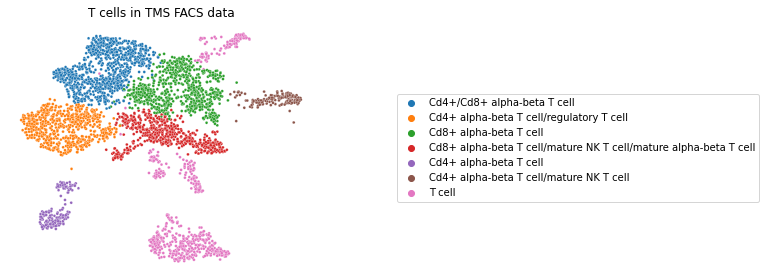

In [6]:
# Figure 
df_plot = pd.DataFrame(index=dic_data_proc['facs'].obs_names,
                       data={'UMAP1':dic_data_proc['facs'].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc['facs'].obsm['X_umap'][:,1]})
df_plot = df_plot.join(dic_data_proc['facs'].obs['leiden_anno'])

plt.figure(figsize=[12,4])
ax = plt.subplot(1,1,1)
ax.axis('off')
g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='leiden_anno', s=8, 
                    hue_order=['Cd4+/Cd8+ alpha-beta T cell', 
                               'Cd4+ alpha-beta T cell/regulatory T cell',
                               'Cd8+ alpha-beta T cell',
                               'Cd8+ alpha-beta T cell/mature NK T cell/mature alpha-beta T cell',
                               'Cd4+ alpha-beta T cell',
                               'Cd4+ alpha-beta T cell/mature NK T cell',
                               'T cell'])
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('T cells in TMS FACS data')
plt.tight_layout()
plt.savefig(FIG_PATH+'/tcell_tms_annot_umap.svg')
plt.savefig(FIG_PATH+'/tcell_tms_annot_umap.png')
plt.show()

### Subpolulation of associated cells 

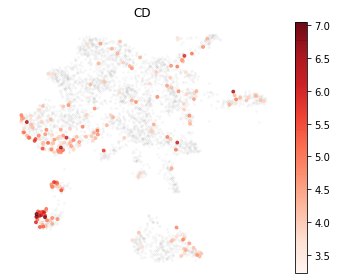

In [6]:
ds = 'facs'
for trait in DIC_TRAIT_LIST[ds]:
        
    plt.figure(figsize=[5,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                           data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1], 
                                 'leiden_anno':dic_data_proc[ds].obs['leiden_anno']})
    df_plot = df_plot.loc[dic_cell_list[ds]]
    df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
    df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

    ind_select = df_plot['%s.fdr'%trait]<0.1
    vmax = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.99) + 0.5
    vmin = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.01) - 0.5
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', s=4, alpha=0.025)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=df_plot.loc[ind_select, '%s.norm_score'%trait],
                cmap='Reds', s=8, vmax=vmax, vmin=vmin, alpha=0.8)
    plt.colorbar()
    plt.title(DF_TRAIT_INFO.loc[trait, 'Code'])

    plt.tight_layout()
    plt.savefig(FIG_PATH+'/sctrs_assoc.%s.%s.svg'%(ds, trait))
    plt.show()
    break

### Annotation for PASS_IBD_deLange2017 associated cells 

... storing 'tissue_celltype' as categorical
... storing 'leiden_sig' as categorical


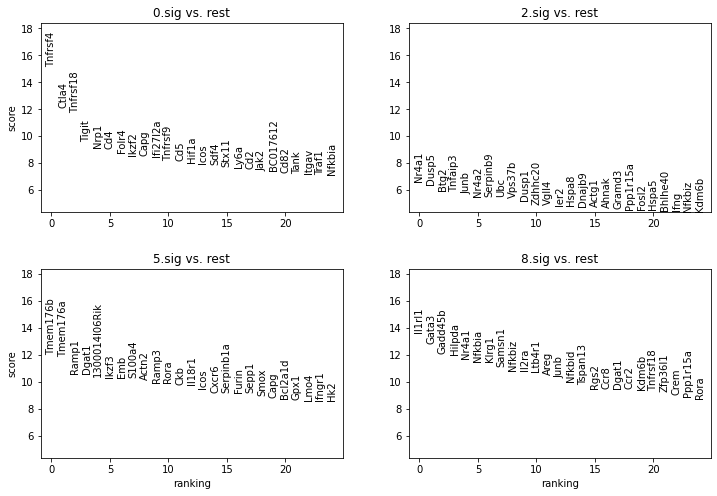

0.sig


,cell
cell_ontology_class,
"CD4-positive, alpha-beta T cell",77.0
"CD8-positive, alpha-beta T cell",4.0
T cell,23.0
regulatory T cell,10.0


2.sig


,cell
cell_ontology_class,
"CD4-positive, alpha-beta T cell",3.0
"CD8-positive, alpha-beta T cell",22.0
T cell,12.0


5.sig


,cell
cell_ontology_class,
"CD4-positive, alpha-beta T cell",2.0
"CD8-positive, alpha-beta T cell",1.0
T cell,61.0
mature NK T cell,1.0


8.sig


,cell
cell_ontology_class,
"CD4-positive, alpha-beta T cell",27.0
"CD8-positive, alpha-beta T cell",1.0
T cell,46.0


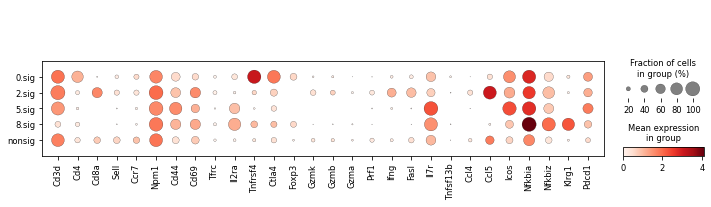

In [14]:
trait = 'PASS_IBD_deLange2017'
ds = 'facs'

# Assign sig label for each leiden cluster (remove sig cells in small clusters)
# adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata = dic_data_raw[ds][dic_cell_list[ds], :].copy()
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obs = adata.obs.join(temp_adata.obs[[x for x in temp_adata.obs.columns if x not in adata.obs.columns]])
adata.obsm = temp_adata.obsm

adata.obs = adata.obs.join(dic_score[ds]['%s.fdr'%trait])
adata.obs['leiden_sig'] = ['%s.sig'%x if y<0.1 else 'nonsig'
                           for x,y in zip(adata.obs['leiden'], adata.obs['%s.fdr'%trait])]


temp_df = adata.obs.groupby(['leiden_sig']).agg({'cell':len})
cluster_remove_list = list(temp_df.index[temp_df['cell']<25])
adata.obs.loc[adata.obs['leiden_sig'].isin(cluster_remove_list), 'leiden_sig'] = 'nonsig' 

# Specifically expressed genes 
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
sc.tl.rank_genes_groups(adata, groupby='leiden_sig', groups=group_list, method='wilcoxon')
# sc.tl.rank_genes_groups(adata, groupby='leiden_sig', reference='nonsig', groups=group_list)
sc.pl.rank_genes_groups(adata, fontsize=10, ncols=2, n_genes=25)

# By tissue 
for group in group_list:
    print(group)
    temp_df = adata.obs.loc[adata.obs['leiden_sig']==group].copy()
    temp_df = temp_df.groupby('cell_ontology_class').agg({'cell':len})
    temp_df = temp_df.loc[temp_df['cell']>0]
    display(temp_df)

# Marker gene expression 
marker_list = ['Cd3d', 'Cd4', 'Cd8a', # Basic
               'Sell', 'Ccr7', 'Npm1', 'Cd44', # Naive Cd44-               
               'Cd69', 'Tfrc', 'Il2ra', 'Tnfrsf4', # Activation: Cd69, Cd71, Cd25 (also Treg)
               'Ctla4', 'Foxp3', # Treg
               'Gzmk', 'Gzmb', 'Gzma', 'Prf1', 'Ifng', 'Fasl', # Cd8+ cytotoxic T cells
               'Il7r', 'Tnfsf13b', 'Ccl4', 'Ccl5', # effector memory
               'Icos', 'Nfkbia', 'Nfkbiz', 'Klrg1', 'Pdcd1', # Others
              ]
sc.pl.dotplot(adata, marker_list, groupby='leiden_sig')

In [9]:
np.where(np.array([x[0] for x in adata.uns['rank_genes_groups']['names']])=='Foxp3')

(array([51]),)

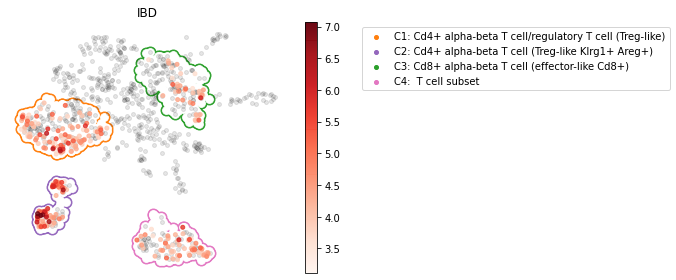

In [8]:
# UMAP plot with annotations 
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
dic_config = {'0.sig': ['C1', 'C1: Cd4+ alpha-beta T cell/regulatory T cell (Treg-like)',
                        'Treg (Ctla4+ Foxp3+ Nrp1+ Tnfrsf18+ Ikzf2+)'], 
              # Ctla4 (Treg), Nrp1 (Treg), Tnfrsf18 (Treg), Ikzf2 (helios, Treg), Tnfrsf4 (OX40, effector)
              '2.sig': ['C2', 'C3: Cd8+ alpha-beta T cell (effector-like Cd8+)', 
                        'Effector Cd8+ T cell (Fasl+ Ifng+)'],
              # Fasl (CD8+ cytotoxic T), Ifng (CD8+ cytotoxic T), Ccl5 (HIV-suppressive factor)
              '5.sig': ['C6', 'C4:  T cell subset', 'T cell'], 
              # Cd4- Cd8-, may not be typical T cells
              '8.sig': ['C4', 'C2: Cd4+ alpha-beta T cell (Treg-like Klrg1+ Areg+)', 
                        'KA Treg (Il1rl1+ Klrg1+ Areg+)']
              # Li_CR_2019 
             }

# Get df_plot 
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['leiden', 'leiden_sig']])
df_plot = df_plot.loc[dic_cell_list[ds]]
df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

# Figure 
plt.figure(figsize=[9.5,4])
ax = plt.subplot(1,1,1)
ax.axis('off')

# Cluster boundry 
x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
for cluster in ['0.sig', '8.sig', '2.sig', '5.sig']:
    ind_select = df_plot['leiden']==cluster.split('.')[0]
    temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
    xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
    xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
    ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
    ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
    ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
                    (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
                s=16, color=dic_config[cluster][0], 
                label=dic_config[cluster][1], zorder=0)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=120, color=dic_config[cluster][0], zorder=1)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=60, color='w', zorder=2)

ind_select_sig = (df_plot['leiden_sig']!='nonsig')
np.random.seed(0)
cell_list_nonsig = np.random.choice(df_plot.index[~ind_select_sig], 
                                    size=int((~ind_select_sig).sum()*0.2), replace=False)
plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
                c='k', s=16, alpha=0.1, zorder=5)

vmax = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.99) + 0.5
vmin = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.01) - 0.5
plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
            c=df_plot.loc[ind_select_sig, '%s.norm_score'%trait],
            cmap='Reds', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
plt.colorbar()
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper left')
plt.title(DF_TRAIT_INFO.loc[trait, 'Code'])
plt.tight_layout()
plt.savefig(FIG_PATH+'/sctrs_assoc.annot_IBD_umap.svg')
plt.savefig(FIG_PATH+'/sctrs_assoc.annot_IBD_umap.png')
plt.show()

... storing 'leiden_sig_anno' as categorical


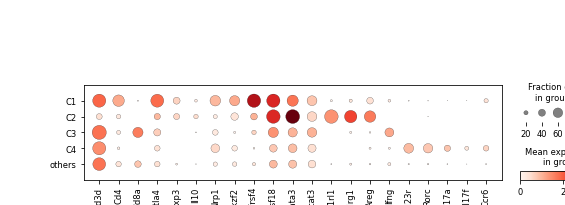

In [24]:
# Also show interesting genes 
gene_plot_list = ['Cd3d', 'Cd4', 'Cd8a',
                  'Ctla4', 'Foxp3', 'Il10', 'Nrp1', 'Ikzf2', 'Tnfrsf4', 'Tnfrsf18',
                  # Il10: Inhibits proinflammatory cytokine expression by innate/adaptive immune cells (Chen 2016)
                  # Treg Ctla4 (Treg), Nrp1 (Treg), Tnfrsf18 (Treg), Ikzf2 (helios, Treg), Tnfrsf4 (OX40, effector)
                  'Il1rl1', 'Klrg1', 'Areg', 
                  # KA Treg
                  'Gzmk', 'Gzmb', 'Gzma', 'Prf1', 'Ifng', 'Fasl',
                  # CTL
                  'Il23r', 'Rorc', 'Il17a', 'Il17f', 'Ccr6',
                  # Th17
                 ]
for gene in gene_plot_list.copy():
    if gene not in adata.var_names:
        print('# missing: %s'%gene)
        gene_plot_list.remove(gene)
adata.obs['leiden_sig_anno'] = [dic_config[x][1].split(':')[0] if x in dic_config else 'others' 
                                for x in adata.obs['leiden_sig']]

sc.pl.dotplot(adata, gene_plot_list, groupby='leiden_sig_anno', 
              categories_order=['C1', 'C2', 'C3', 'C4', 'others'], 
              save='sctrs_assoc.annot_IBD_umap_marker_gene.svg')

In [14]:
# Pathway: enrichr
dic_pathway = {}
group_list = list(adata.uns['rank_genes_groups']['names'].dtype.names)
pw_list = []
for group in group_list:
    df_gene = sc.get.rank_genes_groups_df(adata, group=group)
    gene_list = list(df_gene['names'][:100])

    res = gp.enrichr(gene_list=gene_list, description='pathway',
                         gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2018'],
                         organism='Mouse', outdir=None)
    df_pathway = res.results
    df_pathway = df_pathway.loc[df_pathway['Adjusted P-value']<0.01].copy()
    df_pathway['Intersect'] = [int(x.split('/')[0]) for x in df_pathway['Overlap']]
    df_pathway['Term_size'] = [int(x.split('/')[1]) for x in df_pathway['Overlap']]
    df_pathway['Recall'] = df_pathway['Intersect'] / df_pathway['Term_size']
    dic_pathway[group] = df_pathway.copy()
    ind_select = (df_pathway['Intersect']>10) | (df_pathway['Recall']>0.1)
    ind_select = ind_select & (df_pathway['Term_size']>5) & (df_pathway['Term_size']<500) 
    pw_list.extend(df_pathway.loc[ind_select, 'Term'])

for group in group_list:
    dic_pathway[group].index = dic_pathway[group]['Term']
    dic_pathway[group] = dic_pathway[group].loc[set(dic_pathway[group].index) & set(pw_list)]

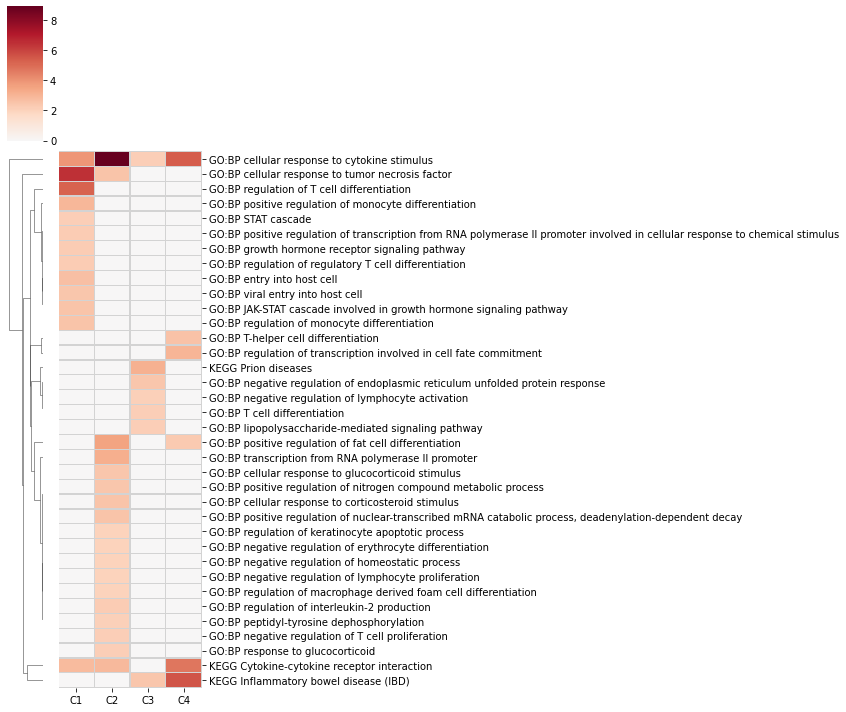

In [15]:
df_plot = pd.DataFrame()
dic_source = {'KEGG_2019_Mouse':'KEGG', 'GO_Biological_Process_2018':'GO:BP', 'Reactome_2016':'REAC'}
for group in group_list:
    temp_df = dic_pathway[group][['Adjusted P-value']]
    temp_df.index = ['%s %s'%(dic_source[x],y.split(' (GO')[0]) 
                     for x,y in zip(dic_pathway[group]['Gene_set'], dic_pathway[group]['Term'])]
    temp_df.columns = [group]
    df_plot = df_plot.join(temp_df, how='outer')

df_plot.fillna(1, inplace=True)
df_plot = -np.log10(df_plot)
# df_plot['max'] = df_plot.max(axis=1)
# df_plot.sort_values(by='max', ascending=False, inplace=True)
# df_plot = df_plot.iloc[:20]
df_plot = df_plot[['0.sig', '8.sig', '2.sig', '5.sig']]
df_plot.index.name = ''
df_plot.columns = [dic_config[x][1].split(':')[0] for x in df_plot.columns]

sns.clustermap(df_plot, metric='euclidean', col_cluster=False, 
               figsize=(12,10), cbar_pos=(0, 0.9, 0.05, 0.05),
               cmap='RdBu_r', center=0, linewidths=0.2, linecolor='lightgrey')
plt.tight_layout()
# plt.savefig(FIG_PATH+'/IBD_pathway.svg')
plt.show()

In [16]:
# Compute genes driving each cluster 
df_gs_gwas = pd.read_csv(GS_FILE, sep='\t', index_col=0)
df_hom = pd.read_csv(DATA_PATH + '/gene_annotation/mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
gwas_gene_list = [dic_map[x] for x in df_gs_gwas.loc[trait, 'GENESET'].split(',') if x in dic_map]
df_contrib = md.compute_gene_contrib(adata, gwas_gene_list)

df_contrib_stats = pd.DataFrame(index=df_contrib.columns, columns=group_list, data=0)
for group in group_list:
    cell_list = list(adata.obs_names[adata.obs['leiden_sig']==group])
    temp_df_sig = df_contrib.loc[cell_list].copy()
    temp_df_rest = df_contrib.loc[~df_contrib.index.isin(cell_list)]
    df_contrib_stats[group] = [sp.stats.ttest_ind(temp_df_sig[x].values, temp_df_rest[x].values)[0]
                               for x in df_contrib.columns]

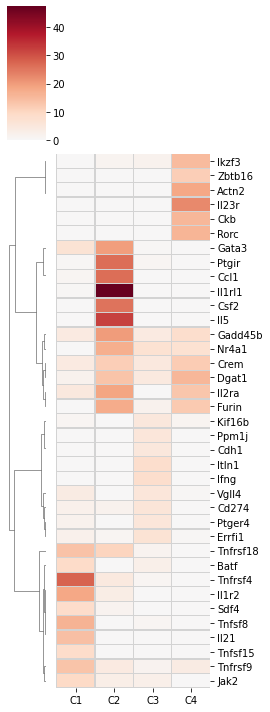

In [17]:
gene_list = []
for group in df_contrib_stats.columns:
    gene_list.extend(df_contrib_stats.sort_values(by=group, ascending=False).index[:10])
gene_list = list(set(gene_list))
df_plot = df_contrib_stats.loc[gene_list]
df_plot.values[df_plot.values<0] = 0
df_plot = df_plot[['0.sig', '8.sig', '2.sig', '5.sig']]
df_plot.columns = [dic_config[x][1].split(':')[0] for x in df_plot.columns]

sns.clustermap(df_plot, metric='cosine', col_cluster=False, figsize=(4,10), 
               cbar_pos=(0, 0.8, 0.05, 0.05), cmap='RdBu_r', center=0, linewidths=0.2, linecolor='lightgrey')
plt.tight_layout()
plt.savefig(FIG_PATH+'/IBD_trs_contrib_gene.svg')
plt.show()

### Per-cluster annotation for PASS_IBD_deLange2017 associated cells 

In [18]:
# Is the selection in each cluster random? 
def p_2_str_num(p_):
    if p_>1/500.5:
        return 'P=%0.3f'%p_
    else:
        return 'P<0.002'
    
df_stats = pd.DataFrame(index=group_list, columns=['C', 'pval'], dtype=float)
# df_stats['C'] = [0.806864, 0.869399, 0.849903, 0.766746]
# df_stats['pval'] = [0.001996, 0.031936, 0.025948, 0.009980]

n_ctrl = 500 
for cluster in group_list: 
    print(cluster)
    cluster_leiden = cluster.split('.')[0]
    temp_adata = dic_data_proc['facs'][dic_data_proc['facs'].obs['leiden']==cluster_leiden,:].copy()
    temp_df = dic_ctrl_score['facs'][trait].loc[temp_adata.obs_names].copy()
    c_ = util.gearys_c(temp_adata, dic_score['facs'].loc[temp_adata.obs_names, '%s.norm_score'%trait])
    v_c_ctrl = np.zeros(n_ctrl)
    for i_ctrl in range(n_ctrl):
        v_c_ctrl[i_ctrl] = util.gearys_c(temp_adata, temp_df['ctrl_norm_score_%d'%i_ctrl])
    df_stats.loc[cluster] = [c_, (np.sum(c_>=v_c_ctrl)+1)/(n_ctrl+1)]

df_stats['pval_str_num'] = [p_2_str_num(x) for x in df_stats['pval']]
display(df_stats)

0.sig
2.sig
5.sig
8.sig


,C,pval,pval_str_num
0.sig,0.806864,0.001996,P<0.002
2.sig,0.869399,0.031936,P=0.032
5.sig,0.849903,0.025948,P=0.026
8.sig,0.766746,0.009980,P=0.010


0.sig


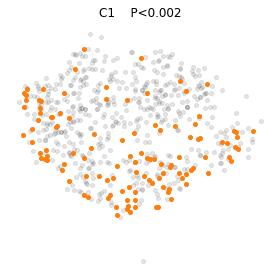

2.sig


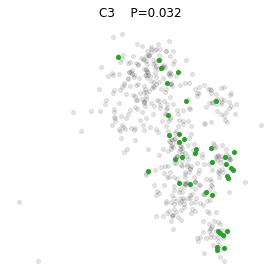

5.sig


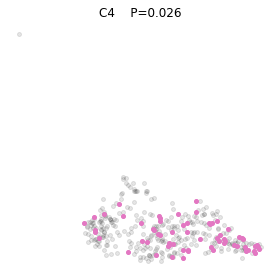

8.sig


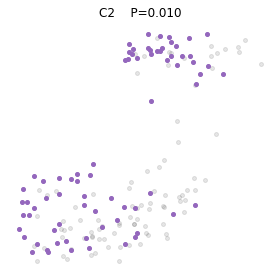

In [19]:
# Per cluster visualization/analysis 
dic_gs = {}
for cluster in group_list: 
    print(cluster)
    cluster_leiden = cluster.split('.')[0]
    temp_adata = adata[adata.obs['leiden']==cluster_leiden,:].copy()
    
    # Figure 
    df_plot = pd.DataFrame(index=temp_adata.obs_names,
                           data={'UMAP1':temp_adata.obsm['X_umap'][:,0],
                                 'UMAP2':temp_adata.obsm['X_umap'][:,1]})
    df_plot = df_plot.join(temp_adata.obs['leiden_sig'])

    plt.figure(figsize=[4,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    ind_select = df_plot['leiden_sig']!='nonsig'
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', alpha=0.1, s=16)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=dic_config[cluster][0], s=16)
    plt.title(dic_config[cluster][1].split(':')[0]+'    %s'%df_stats.loc[cluster, 'pval_str_num'])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/IBD_umap.%s.svg'%cluster_leiden)
    plt.savefig(FIG_PATH+'/IBD_umap.%s.png'%cluster_leiden)
    plt.show()

... storing 'leiden_sig_new' as categorical


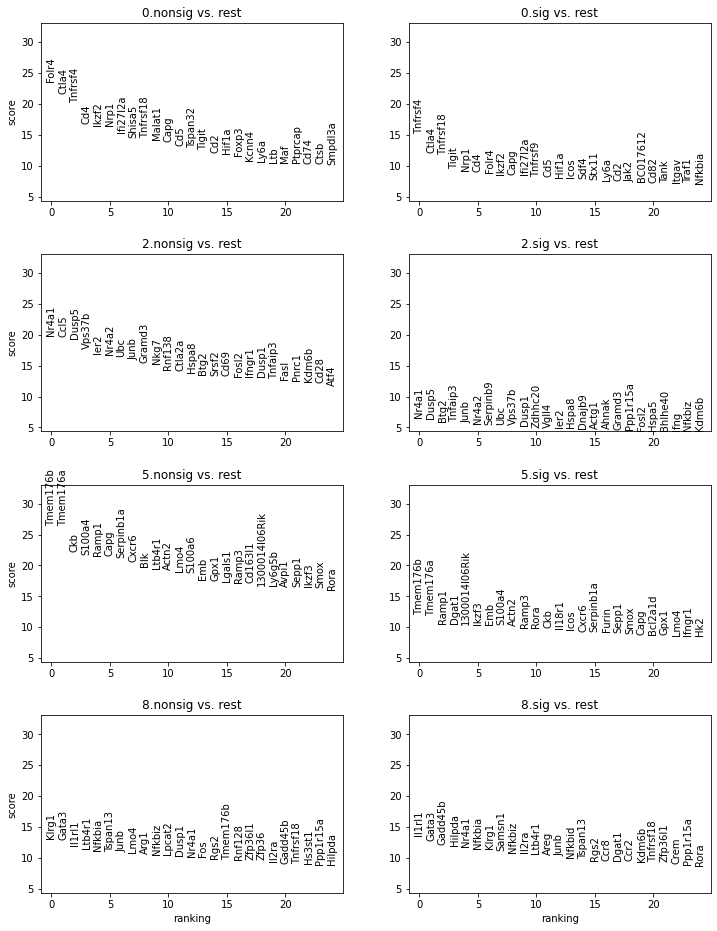

In [20]:
temp_adata = adata.copy()
temp_adata.obs['leiden_sig_new'] = [x for x in temp_adata.obs['leiden_sig']]
for group in group_list:
    ind_select = (temp_adata.obs['leiden_sig']=='nonsig') & (temp_adata.obs['leiden']==group.split('.')[0])
    temp_adata.obs.loc[ind_select, 'leiden_sig_new'] = group.replace('sig', 'nonsig')

group_list_new = sorted([x for x in temp_adata.obs['leiden_sig_new'].unique() if ('.sig' in x) | ('.nonsig' in x)])
sc.tl.rank_genes_groups(temp_adata, groupby='leiden_sig_new', groups=group_list_new, method='wilcoxon')
sc.pl.rank_genes_groups(temp_adata, fontsize=10, ncols=2, n_genes=25)

In [21]:
# Pathway: enrichr
dic_pathway = {}
pw_list = []
for group in group_list_new:
    df_gene = sc.get.rank_genes_groups_df(temp_adata, group=group)
    gene_list = list(df_gene['names'][:100])

    res = gp.enrichr(gene_list=gene_list, description='pathway',
                         gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2018'],
                         organism='Mouse', outdir=None)
    df_pathway = res.results
    df_pathway = df_pathway.loc[df_pathway['Adjusted P-value']<0.01].copy()
    df_pathway['Intersect'] = [int(x.split('/')[0]) for x in df_pathway['Overlap']]
    df_pathway['Term_size'] = [int(x.split('/')[1]) for x in df_pathway['Overlap']]
    df_pathway['Recall'] = df_pathway['Intersect'] / df_pathway['Term_size']
    dic_pathway[group] = df_pathway.copy()
    ind_select = (df_pathway['Intersect']>10) | (df_pathway['Recall']>0.1)
    ind_select = ind_select & (df_pathway['Term_size']>5) & (df_pathway['Term_size']<500) 
    pw_list.extend(df_pathway.loc[ind_select, 'Term'])

for group in group_list_new:
    dic_pathway[group].index = dic_pathway[group]['Term']
    dic_pathway[group] = dic_pathway[group].loc[set(dic_pathway[group].index) & set(pw_list)]

0.sig


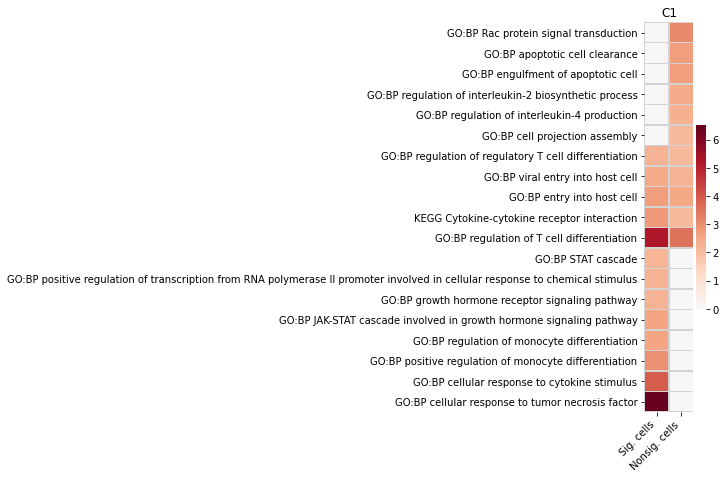

2.sig


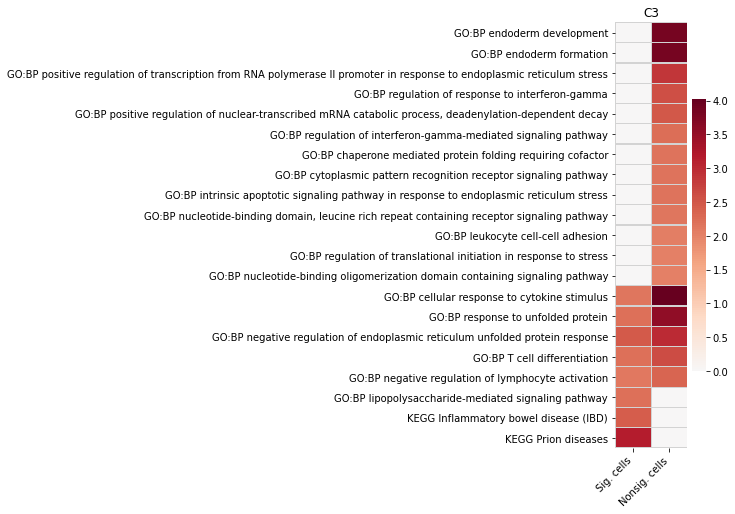

5.sig


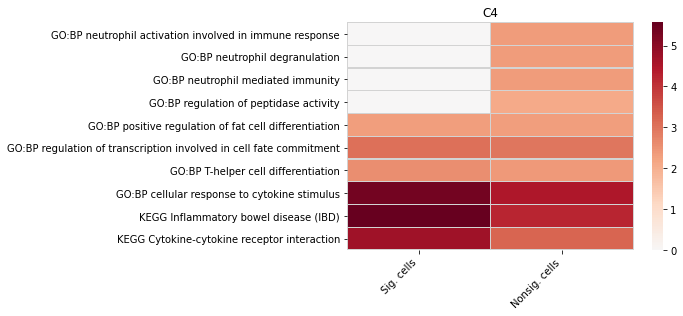

8.sig


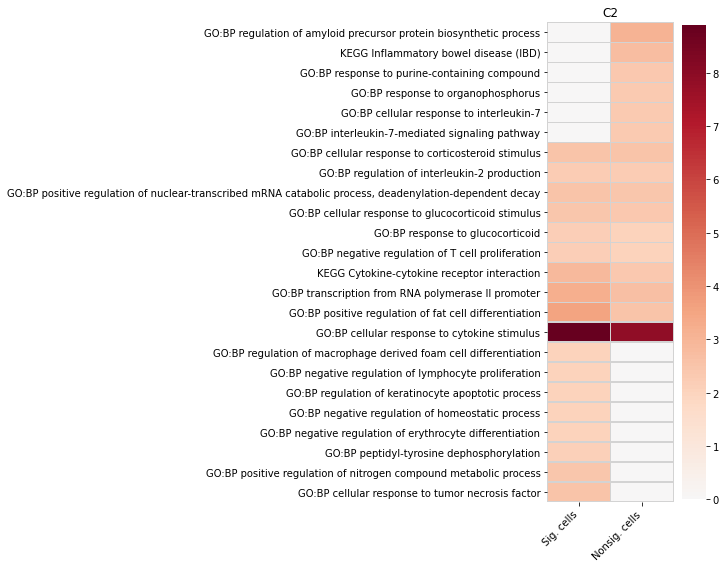

In [22]:
for cluster in group_list:
    print(cluster)
    df_plot = pd.DataFrame()
    for group in [cluster, cluster.replace('sig', 'nonsig')]:
        temp_df = dic_pathway[group][['Adjusted P-value']]
        temp_df.index = ['%s %s'%(dic_source[x],y.split(' (GO')[0]) 
                         for x,y in zip(dic_pathway[group]['Gene_set'], dic_pathway[group]['Term'])]
        temp_df.columns = [group]
        df_plot = df_plot.join(temp_df, how='outer')

    df_plot.fillna(1, inplace=True)
    df_plot = -np.log10(df_plot)
#     df_plot = df_plot.loc[df_plot.max(axis=1)>3]
    df_plot.index.name = ''
    df_plot['dif'] = df_plot.iloc[:,0] - df_plot.iloc[:,1]
    df_plot.sort_values(by='dif', inplace=True)
    df_plot = df_plot[[cluster, cluster.replace('sig', 'nonsig')]]
    df_plot.columns = ['Sig. cells', 'Nonsig. cells']
    
    if df_plot.shape[0]==0:
        continue
    plt.figure(figsize=[10, 2+0.25*df_plot.shape[0]])
    sns.heatmap(df_plot, cmap='RdBu_r', center=0, linewidths=0.2, linecolor='lightgrey')
    plt.title(dic_config[cluster][1].split(':')[0])
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/IBD_pathway.nonsig.%s.svg'%cluster)
    plt.show()
#     break

### Correlating with cd4/cd8 effector gradient

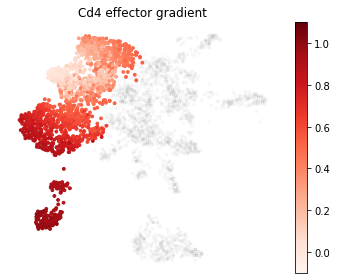

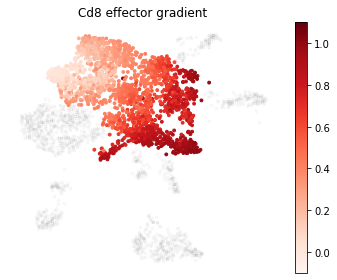

In [23]:
# Pseudotime: make it nicer later 
adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
dic_title = {'dpt_cd4_qn': 'Cd4 effectorness gradient', 
             'dpt_cd8_qn': 'Cd8 effectorness gradient'}
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['dpt_cd4_qn', 'dpt_cd8_qn']])

for term in ['dpt_cd4_qn', 'dpt_cd8_qn']:    
    plt.figure(figsize=[5,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    ind_select = df_plot[term]>0
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', alpha=0.025, s=8)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=df_plot.loc[ind_select, term], cmap='Reds', vmax=1.1, vmin=-0.1, s=8)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title(dic_title[term])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/%s.svg'%term)
    plt.show()
#     break

In [24]:
# Compute p-value
adata = dic_data_proc['facs'].copy()
df_stats = pd.DataFrame(columns=['DPT', 'TRAIT', 'CORR', 'P'])

for dpt in ['dpt_cd4_qn', 'dpt_cd8_qn']:
    for score in ['facs', 'facs_tsig']:
        for trait in DIC_TRAIT_LIST[score]:
            df_plot = adata.obs[[dpt]].copy()
            df_plot = df_plot.loc[df_plot[dpt]>0]
            df_plot = df_plot.join(dic_score[score].loc[adata.obs_names, ['%s.norm_score'%trait]])
            df_plot = df_plot.join(dic_ctrl_score[score][trait])
            corr_ = sp.stats.pearsonr(df_plot[dpt].values, df_plot['%s.norm_score'%trait].values)[0]
            v_corr_ = np.zeros(500)
            for i in range(500):
                v_corr_[i] = sp.stats.pearsonr(df_plot[dpt].values, df_plot['ctrl_norm_score_%d'%i].values)[0]
            p_ = ((np.absolute(corr_) <= np.absolute(v_corr_)).sum()+1) / 501
            df_stats.loc['%s.%s'%(dpt,trait)] = [dpt, trait, corr_, p_]
            
def p_2_str(p_):
    if p_>0.05:
        return 'n.s.'
    elif p_>0.01:
        return '*'
    elif p_>0.005:
        return '**'
    else: 
        return '***'
    
def p_2_str_num(p_):
    if p_>1/500.5:
        return 'P=%0.3f'%p_
    else:
        return 'P<0.002'
    
df_stats['P_STR'] = [p_2_str(x) for x in df_stats['P']]
df_stats['P_STR_NUM'] = [p_2_str_num(x) for x in df_stats['P']]

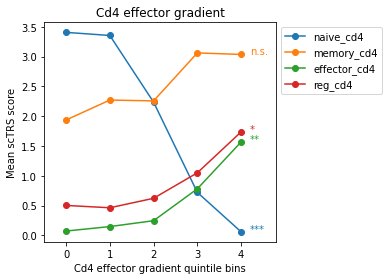

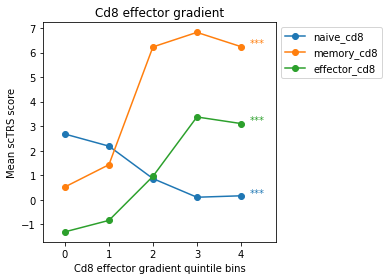

In [25]:
# T cell signatures
adata = dic_data_proc['facs'].copy()
plot_list = [['dpt_cd4_qn', ['naive_cd4', 'memory_cd4', 'effector_cd4', 'reg_cd4']],
             ['dpt_cd8_qn', ['naive_cd8', 'memory_cd8', 'effector_cd8']] ]

ds = 'facs_tsig'

for temp_list in plot_list:
    term,sig_list = temp_list
    df_plot = adata.obs[[term]].copy()
    df_plot = df_plot.loc[df_plot[term]>0]
    df_plot = df_plot.join(dic_score[ds].loc[adata.obs_names, ['%s.norm_score'%x for x in sig_list]])
    df_plot['bin'] = pd.qcut(df_plot[term], q=5, labels=False)
    
    plt.figure(figsize=[5.5,4])
    i_color = 0
    for sig in sig_list:
        temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%sig: np.mean})
        plt.plot(temp_df.index, temp_df['%s.norm_score'%sig], 'o-', label=sig, color='C%d'%i_color)
        plt.text(4.2, temp_df['%s.norm_score'%sig][4], df_stats.loc['%s.%s'%(term,sig),'P_STR'],
                 color='C%d'%i_color)
        i_color+=1
    
    plt.xlim([-0.5,4.8])
    plt.legend(bbox_to_anchor=[1,1], loc='upper left')
    plt.xlabel('%s quintile bins'%dic_title[term])
    plt.ylabel('Mean scTRS score')
    plt.title(dic_title[term])
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/dpt_tsig_corr.%s.svg'%term)
    plt.show()
    

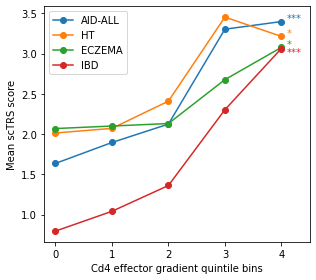

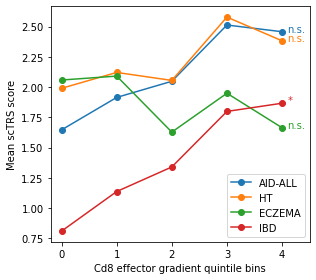

In [26]:
# Correlate with trait signal
adata = dic_data_proc['facs'].copy()
trait_list_plot = ['PASS_IBD_deLange2017', 'UKB_460K.disease_AID_ALL',
                   'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',]
ds = 'facs'

# Reorder traits 
dpt_q80 = np.quantile(adata.obs.loc[adata.obs['dpt_cd4']>0, 'dpt_cd4'], 0.8)
cell_list = adata.obs_names[adata.obs['dpt_cd4']>dpt_q80]
temp_df = pd.DataFrame(index=trait_list_plot,
                       data={'score': [dic_score[ds].loc[cell_list, '%s.norm_score'%x].mean()
                                       for x in trait_list_plot]})
temp_df.sort_values(by='score', ascending=False, inplace=True)
trait_list_plot = list(temp_df.index)

for term in ['dpt_cd4_qn', 'dpt_cd8_qn']:
    i_color = 0
    y_text = 5
    plt.figure(figsize=[4.5,4])
    for i_trait,trait in enumerate(trait_list_plot):

        df_plot = adata.obs[[term]].copy()
        df_plot = df_plot.loc[df_plot[term]>0]
        df_plot['bin'] = pd.qcut(df_plot[term], q=5, labels=False)
        df_plot = df_plot.join(dic_score[ds].loc[adata.obs_names, '%s.norm_score'%trait])

        temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%trait: np.mean})
        temp_df.columns = ['mean']

        plt.plot(temp_df.index, temp_df['mean'], 'o-', label=DF_TRAIT_INFO.loc[trait, 'Code'], 
                 color='C%d'%i_color)
        if term=='dpt_cd4_qn':
            y_text = min(y_text-0.1, temp_df['mean'][4])
        else:
            y_text = temp_df['mean'][4]
        plt.text(4.1, y_text, df_stats.loc['%s.%s'%(term,trait),'P_STR'], color='C%d'%i_color)
        i_color += 1
        
    plt.xlim([-0.2,4.5])
    plt.ylabel('Mean scTRS score')
    plt.xlabel('%s quintile bins'%dic_title[term])
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/dpt_trait_corr.%s.svg'%term)
    plt.show()

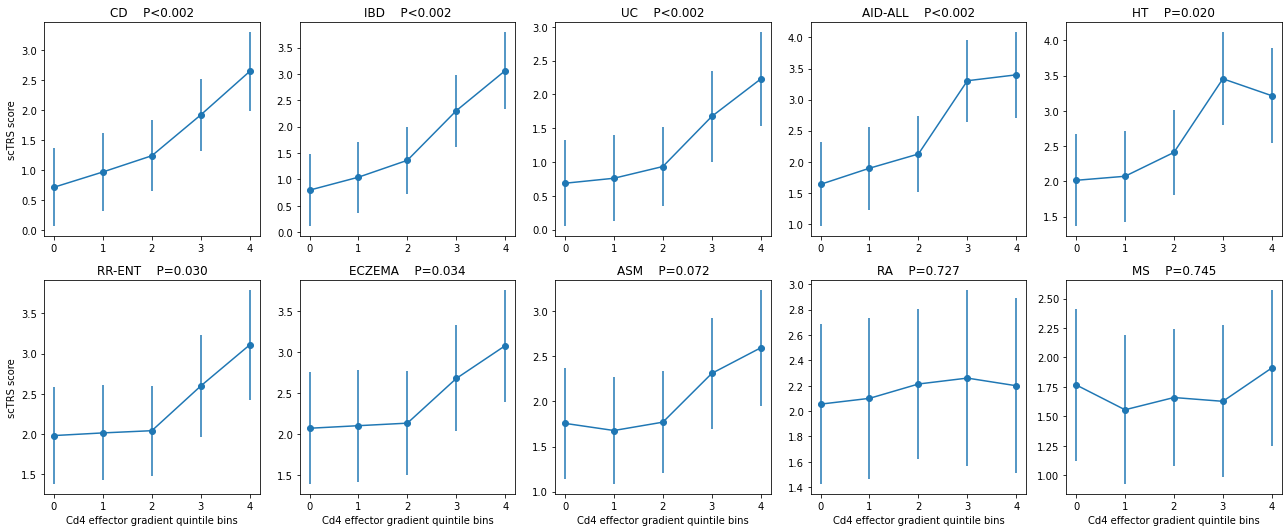

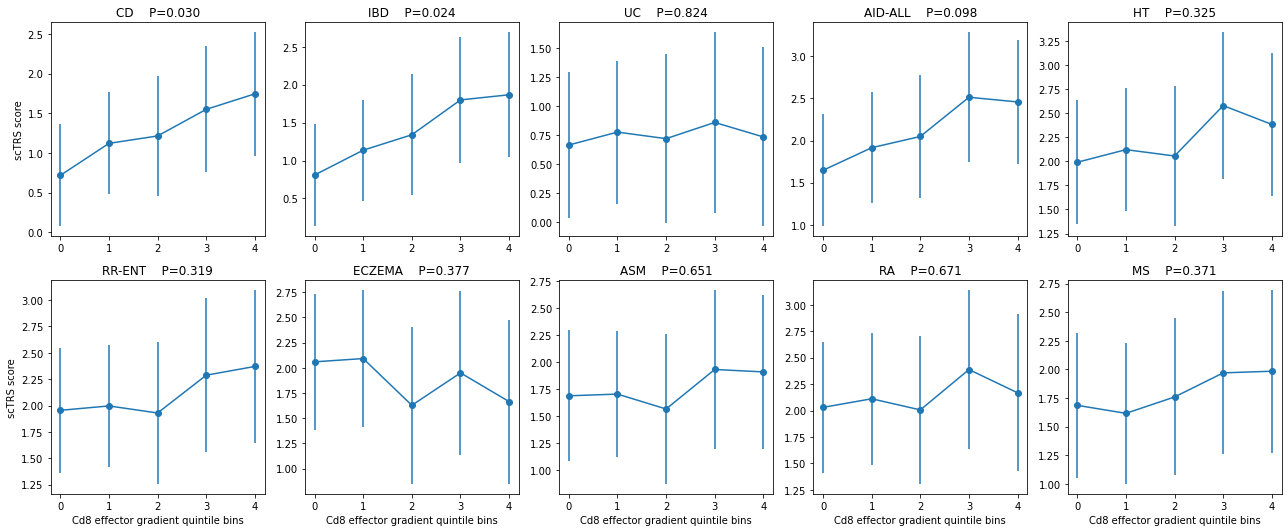

In [27]:
adata = dic_data_proc['facs'].copy()
trait_list_plot = sorted(DIC_TRAIT_LIST['facs'])
ds = 'facs'

temp_df = df_stats.loc[['dpt_cd4_qn.%s'%x for x in trait_list_plot]].copy()
temp_df.sort_values(by='P', inplace=True)
temp_list = [x.replace('dpt_cd4_qn.','') for x in temp_df.index]

nrow,ncol =2,5
for term in ['dpt_cd4_qn', 'dpt_cd8_qn']:
    plt.figure(figsize=[18, 7.5])
    for i_trait,trait in enumerate(temp_list):
        plt.subplot(nrow,ncol,i_trait+1)
        
        df_plot = adata.obs[[term]].copy()
        df_plot = df_plot.loc[df_plot[term]>0]
        df_plot['bin'] = pd.qcut(df_plot[term], q=5, labels=False)
        df_plot = df_plot.join(dic_score[ds].loc[adata.obs_names, '%s.norm_score'%trait])
        df_plot = df_plot.join(dic_ctrl_score[ds][trait])
        
        temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%trait: np.mean})
        temp_df.columns = ['mean']
        temp_df_std = df_plot.groupby('bin').agg({'ctrl_norm_score_%d'%x: np.mean for x in range(500)}).std(axis=1)
        temp_df['std'] = temp_df_std.loc[temp_df.index].values
        
        plt.errorbar(temp_df.index, temp_df['mean'], yerr = temp_df['std']*1.96, fmt='-o', 
                     label=DF_TRAIT_INFO.loc[trait, 'Code'])
        plt.title(DF_TRAIT_INFO.loc[trait, 'Code']+'    ' + df_stats.loc['%s.%s'%(term,trait),'P_STR_NUM'])
        if i_trait>=ncol*(nrow-1):
            plt.xlabel('%s quintile bins'%dic_title[term])
        else:
            plt.xlabel('')
        if i_trait%ncol==0:
            plt.ylabel('scTRS score')
        else:
            plt.ylabel('')
        
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/dpt_trait_corr_all.%s.svg'%term)
    plt.show()

### Prioritize gene sets 

In [28]:
df_gs_gwas = pd.read_csv(GS_FILE, sep='\t', index_col=0)
df_hom = pd.read_csv(DATA_PATH + '/gene_annotation/mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
background_set = set(dic_data_raw['facs'].var_names) & set(dic_map.values())

In [29]:
# T cell specific genes 
temp_adata = dic_data_raw['facs'][:, list(background_set)].copy()
temp_adata.obs['tcell'] = 'nt'
temp_adata.obs.loc[dic_data_proc['facs'].obs_names, 'tcell'] = 't'
sc.tl.rank_genes_groups(temp_adata, groupby='tcell', groups=['t'])
df_t = sc.get.rank_genes_groups_df(temp_adata, 't')

... storing 'tissue_celltype' as categorical
... storing 'tcell' as categorical


In [30]:
# GWAS and scTRS gene sets 
dic_gs = {}

for trait in DIC_TRAIT_LIST['facs']:
    
    # GWAS gene set
    dic_gs['%s.gwas'%trait] = set([dic_map[x] for x in df_gs_gwas.loc[trait, 'GENESET'].split(',') if x in dic_map])
    dic_gs['%s.gwas'%trait] = dic_gs['%s.gwas'%trait] & background_set
    
    # scTRS gene set
    temp_adata = dic_data_raw['facs'][dic_data_proc['facs'].obs_names, list(background_set)].copy()
    temp_adata.obs['sctrs'] = dic_score['facs'].loc[temp_adata.obs_names, '%s.norm_score'%trait]
    md.correlate_gene(temp_adata, trs_name='sctrs', corr_opt='pearson', cov_list=None)
    df_gene_corr = pd.DataFrame(index=temp_adata.var_names)
    df_gene_corr[trait] = temp_adata.var[['trs_corr']].copy()
    df_gene_corr.sort_values(by=trait, ascending=False, inplace=True)
    dic_gs['%s.sctrs'%trait] = set(df_gene_corr.index[:len(dic_gs['%s.gwas'%trait])])
    
    # tcell-specific genes 
    dic_gs['%s.tcell'%trait] = set(df_t['names'][:len(dic_gs['%s.gwas'%trait])])

In [31]:
# Gold standard gene sets 
dic_ref = {'PASS_IBD_deLange2017': 'Fang_NG_2019:UC.drug_target;Fang_NG_2019:CRO.drug_target',
           'PASS_CD_deLange2017': 'Fang_NG_2019:CRO.drug_target',
           'PASS_UC_deLange2017': 'Fang_NG_2019:UC.drug_target',            
           'PASS_Multiple_sclerosis': 'Fang_NG_2019:MS.drug_target',
           'PASS_Rheumatoid_Arthritis': 'Fang_NG_2019:RA.drug_target',
           'UKB_460K.disease_AID_ALL': 'Freund_AJHG_2018:Immune_Dysregulation',
           'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED': 'Fang_NG_2019:ALG.drug_target',
           'UKB_460K.disease_ASTHMA_DIAGNOSED': 'Fang_NG_2019:ASM.drug_target',
           'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP': 'Freund_AJHG_2018:Immune_Dysregulation',
           'UKB_460K.disease_RESPIRATORY_ENT': 'Fang_NG_2019:ASM.drug_target'
            }
for trait in dic_ref: 
     dic_gs['%s.ref'%trait] = set()
        
for gs_ref in ['Fang_NG_2019', 'Freund_AJHG_2018']:
    df_gs_gold = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gold_standard_gs/%s.gs'%gs_ref,
                         sep='\t', index_col=0)
    for trait in dic_ref:
        for trait_ref in dic_ref[trait].split(';'):
            if gs_ref in trait_ref:
                trait_ref = trait_ref.replace('%s:'%gs_ref,'')
                dic_gs['%s.ref'%trait] = dic_gs['%s.ref'%trait] | \
                    set([dic_map[x] for x in df_gs_gold.loc[trait_ref, 'GENESET'].split(',') if x in dic_map])

In [32]:
# Compute stats 
dic_stats = {}
for res in ['gwas', 'sctrs', 'tcell']:
    dic_stats[res] = pd.DataFrame(columns=['GWAS', 'GS', 'overlap', 'odds_ratio', 'odds_ratio.ub',
                                           'odds_ratio.lb', 'pval', 'overlap_gene'], dtype=float)
    for trait in dic_ref:
        gs_set = dic_gs['%s.%s'%(trait, res)] & background_set
        ge_set_ref = dic_gs['%s.ref'%trait] & background_set
        pvalue,oddsratio,or_ub,or_lb = util.test_overlap(gs_set, ge_set_ref, background_set)

        dic_stats[res].loc[trait,'GWAS'] = len(gs_set)
        dic_stats[res].loc[trait,'GS'] = len(ge_set_ref)
        dic_stats[res].loc[trait,'overlap'] = len(gs_set & ge_set_ref)
        dic_stats[res].loc[trait,'odds_ratio'] = oddsratio
        dic_stats[res].loc[trait,'odds_ratio.ub'] = or_ub
        dic_stats[res].loc[trait,'odds_ratio.lb'] = or_lb
        dic_stats[res].loc[trait,'pval'] = pvalue
        dic_stats[res].loc[trait,'overlap_gene'] = ','.join(sorted(gs_set & ge_set_ref))

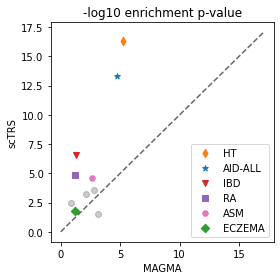

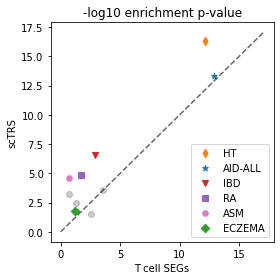

In [34]:
# Scatter plot for comparison 
dic_config = {'gwas': ['C0', 'MAGMA'], 
              'sctrs': ['C1', 'scTRS'], 
              'tcell': ['C2', 'T cell SEGs']}

dic_config_trait = {'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP': ['C1', 'd'], 
                    'UKB_460K.disease_AID_ALL': ['C0', '*'], 
                    'PASS_IBD_deLange2017': ['C3', 'v'], 
                    'PASS_Rheumatoid_Arthritis': ['C4', 's'],
                    'UKB_460K.disease_ASTHMA_DIAGNOSED': ['C6', 'H'],
                    'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED': ['C2', 'D']                   
                    }

df_plot = dic_stats[res][['GS']].copy()
for res in dic_config:
    df_plot['%s.nlog10pval'%res] = -np.log10(dic_stats[res].loc[df_plot.index, 'pval'].values)
df_plot = df_plot.astype(dtype=float)
df_plot['loc'] = range(df_plot.shape[0])

for res_ref in ['gwas', 'tcell']:
    plt.figure(figsize=[4,4])
    ind_select = (~df_plot.index.isin(dic_config_trait.keys()))
    plt.scatter(df_plot.loc[ind_select, '%s.nlog10pval'%res_ref], df_plot.loc[ind_select, 'sctrs.nlog10pval'],
                color='k', alpha=0.2)
    for trait in dic_config_trait:
        plt.scatter(df_plot.loc[trait, '%s.nlog10pval'%res_ref], df_plot.loc[trait, 'sctrs.nlog10pval'], 
                    color=dic_config_trait[trait][0], marker=dic_config_trait[trait][1], 
                    label=DF_TRAIT_INFO.loc[trait, 'Code'])
    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    max_ = max(xmax, ymax)
    plt.plot([0, max_], [0, max_], '--', color='k', alpha=0.6)
    plt.xlabel(dic_config[res_ref][1])
    plt.ylabel(dic_config['sctrs'][1])
    plt.title('-log10 enrichment p-value')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/comparison_gs_%s.svg'%res_ref)
    plt.show()

# Old code 

In [ ]:
# # Pathway 
# dic_pathway = {}
# group_list = list(adata.uns['rank_genes_groups']['names'].dtype.names)
# pw_list = []
# for group in group_list:   
#     df_gene = sc.get.rank_genes_groups_df(adata, group=group)
#     gene_list = list(df_gene['names'][:100])
    
#     # g:profiler 
#     gp = GProfiler(return_dataframe=True)
#     df_pathway = gp.profile(organism=DIC_INFO[ds]['species'], 
#                             query=gene_list,
#                             sources=['KEGG', 'GO:BP', 'REAC'],
#                             significance_threshold_method='fdr', 
#                             user_threshold=0.01,
#                             background=list(adata.var_names))
#     dic_pathway[group] = df_pathway.copy()
#     ind_select = (df_pathway['intersection_size']>10) | (df_pathway['recall']>0.1)
#     ind_select = ind_select & (df_pathway['term_size']<500) & (df_pathway['term_size']>5)
#     pw_list.extend(df_pathway.loc[ind_select, 'name'])

# for group in group_list:
#     dic_pathway[group].index = dic_pathway[group]['name']
#     dic_pathway[group] = dic_pathway[group].loc[set(dic_pathway[group].index) & set(pw_list)]

In [ ]:
# df_plot = pd.DataFrame()
# for group in group_list:
#     temp_df = dic_pathway[group][['p_value']]
#     temp_df.index = ['%s %s'%(x,y) for x,y in zip(dic_pathway[group]['source'], dic_pathway[group]['name'])]
#     temp_df.columns = [group]
#     df_plot = df_plot.join(temp_df, how='outer')
    
# df_plot.fillna(1, inplace=True)
# df_plot = -np.log10(df_plot)
# df_plot = df_plot[['0.sig', '8.sig', '2.sig', '5.sig']]
# df_plot.index.name = ''
# df_plot.columns = [dic_config[x][1].split(':')[0] for x in df_plot.columns]

# sns.clustermap(df_plot, col_cluster=False, figsize=(8,12), cbar_pos=(0, 0.9, 0.05, 0.05),
#                cmap='Reds', linewidths=0.2, linecolor='lightgrey')
# plt.tight_layout()
# plt.savefig(FIG_PATH+'/IBD_pathway.svg')
# plt.show()

In [ ]:
# dic_config = {'gwas': ['C0', 'GWAS'], 
#               'sctrs': ['C1', 'scTRS'], 
#               'tcell': ['C2', 'T cell SEGs']}

# df_plot = dic_stats[res][['GS']].copy()
# for res in dic_config:
#     df_plot['%s.nlog10pval'%res] = -np.log10(dic_stats[res].loc[df_plot.index, 'pval'].values)
# df_plot = df_plot.astype(dtype=float)
# df_plot['loc'] = range(df_plot.shape[0])


# plt.figure(figsize=[4, 4])
# for i_res,res in enumerate(['gwas', 'tcell', 'sctrs']):
#     mat_xerr = np
#     plt.bar(df_plot['loc']+0.2*i_res-0.2, df_plot['%s.nlog10pval'%res],
#             width=0.2, color=dic_config[res][0], label=dic_config[res][1])

# fwer_thres = -np.log10(0.05/df_plot.shape[0])
# plt.plot([-0.5, df_plot.shape[0]-0.5], [fwer_thres, fwer_thres], color='k', linestyle='--', 
#          label='FWER=0.05')

# plt.legend()
# plt.xticks(df_plot['loc'], [DF_TRAIT_INFO.loc[x, 'Code'] for x in df_plot.index], rotation=30, ha='right')
# plt.ylabel('Enrichment p-value')
# plt.xlim([-0.5, df_plot.shape[0]-0.5])
# plt.tight_layout()
# plt.savefig(FIG_PATH+'/comparison_gs.svg')
# plt.show()